In [150]:
# COMP9517 Group Project

In [151]:
### Model 1 : KNN

# Please run this file after dataVisualisation.ipynb. Afterwards, you can run any model in any order.

In [152]:
import numpy as np
import cv2 as cv
from pycocotools.coco import COCO
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import albumentations as A
import os
import matplotlib.pyplot as plt


In [153]:
# Define transformation for resizing and normalizing
resize_transform = A.Compose([
    A.Resize(128, 128),  # Resize images to a consistent size
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

class SeaTurtleDatasetForKNN(Dataset):
    def __init__(self, image_ids, transform=None):
        self.coco = COCO("./turtles-data/data/updated_annotations.json")
        self.image_ids = image_ids
        self.cat_ids = self.coco.getCatIds()
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        # Load image
        image_id = self.image_ids[index]
        image_data = self.coco.loadImgs([image_id])[0]

        image_path = os.path.join("./turtles-data/data", image_data["file_name"])
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # Prepare mask
        mask = self._getmask(image_id, image)

        # Apply transformations
        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented["image"]
            mask = cv.resize(mask, (128, 128), interpolation=cv.INTER_NEAREST)

        # Flatten images and masks for KNN input
        return image.flatten(), mask.flatten()

    def _getmask(self, image_id, image):
        """
        Generate mask with labels for each category.
        """
        categories = {"turtle": 1, "flipper": 2, "head": 3}
        # Initialize the final mask with zeros
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        # Process each category
        for category_name, category_id in categories.items():
            ann_ids = self.coco.getAnnIds(imgIds=image_id, catIds=category_id, iscrowd=None)
            annotations = self.coco.loadAnns(ann_ids)

            # Create a temporary mask for the current category
            temp_mask = np.zeros_like(mask)
            for ann in annotations:
                temp_mask += self.coco.annToMask(ann)
            
            # Assign category-specific value to the final mask
            if category_name == "turtle":
                mask[temp_mask > 0] = 1
            elif category_name == "flipper":
                mask[temp_mask > 0] = 2
            elif category_name == "head":
                mask[temp_mask > 0] = 3

        return mask

In [154]:
# Load metadata and map image IDs
metadata_path = "./turtles-data/data/metadata_splits.csv"
metadata = pd.read_csv(metadata_path)

In [155]:
# Initialize the COCO object once
coco = SeaTurtleDatasetForKNN([]).coco

# Get all image IDs once
image_ids = coco.getImgIds()

# Create the img_to_filename dictionary
img_to_filename = {img_id: coco.loadImgs(img_id)[0]["file_name"] for img_id in image_ids}

# Create the reverse mapping file_to_img dictionary
file_to_img = {v: k for k, v in img_to_filename.items()}


loading annotations into memory...
Done (t=133.94s)
creating index...
index created!


In [156]:
# Get image IDs for each split
train_img_ids = [file_to_img[filename] for filename in metadata[metadata["split_open"] == "train"]["file_name"] if filename in file_to_img]
val_img_ids = [file_to_img[filename] for filename in metadata[metadata["split_open"] == "valid"]["file_name"] if filename in file_to_img]
test_img_ids = [file_to_img[filename] for filename in metadata[metadata["split_open"] == "test"]["file_name"] if filename in file_to_img]


In [157]:
# Create limited Subset datasets with only 200 samples for training and 100 for testing
train_dataset = Subset(SeaTurtleDatasetForKNN(train_img_ids, transform=resize_transform), range(200))
test_dataset = Subset(SeaTurtleDatasetForKNN(test_img_ids, transform=resize_transform), range(100))


loading annotations into memory...
Done (t=15.79s)
creating index...
index created!
loading annotations into memory...
Done (t=136.73s)
creating index...
index created!


In [158]:
# Create DataLoaders
batch_size = 4
num_workers = 0
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [159]:
# Prepare the data for KNN by processing in batches
X_train, y_train = [], []

print("Processing training data...")

for idx, (images, masks) in enumerate(train_loader):
    for img, mask in zip(images, masks):
        img_np = img.numpy().reshape(-1, 3)  # Flatten image to (16384, 3)
        mask_np = mask.numpy().flatten()     # Flatten mask to (16384,)

        # Check for size mismatch
        if img_np.shape[0] != mask_np.shape[0]:
            print(f"Skipping image {idx} due to size mismatch.")
            print(f"\tImage {idx}: img_np: {img_np.shape}, mask_np: {mask_np.shape}")
            continue

        # Append the entire flattened arrays
        X_train.append(img_np)
        y_train.append(mask_np)

print("Finished processing training data.")

Processing training data...
Finished processing training data.


In [160]:
# Prepare test data
X_test, y_test = [], []

print("Processing testing data...")

# Iterate over DataLoader batches
for idx, (images, masks) in enumerate(test_loader):
    for img, mask in zip(images, masks):
        img_np = img.numpy().reshape(-1, 3)  # Flatten image to (16384, 3)
        mask_np = mask.numpy().flatten()     # Flatten mask to (16384,)

        if img_np.shape[0] != mask_np.shape[0]:
            print(f"Skipping image {idx} due to size mismatch.")
            print(f"\tImage {idx}: img_np: {img_np.shape}, mask_np: {mask_np.shape}")
            continue

        X_test.append(img_np)
        y_test.append(mask_np)

print("Finished processing testing data.")

Processing testing data...
Finished processing testing data.


In [161]:
# Convert lists to numpy arrays
try:
    X_train = np.vstack(X_train)  # Shape should be (num_samples * 16384, 3)
    y_train = np.concatenate(y_train).astype(int)  # Shape should be (num_samples * 16384,)
    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test).astype(int)
except ValueError as e:
    print(f"Error converting to numpy arrays: {e}")
    print(f"X_train sample shapes: {[x.shape for x in X_train[:5]]}")
    print(f"y_train sample shapes: {[y.shape for y in y_train[:5]]}")
    raise e

# Print shapes for debugging
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (3276800, 3), y_train shape: (3276800,)
X_test shape: (1638400, 3), y_test shape: (1638400,)


In [162]:
# Initialize and train KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [163]:
# Predict and evaluate
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88   1405552
           1       0.24      0.34      0.29    146533
           2       0.11      0.17      0.14     54270
           3       0.03      0.05      0.04     32045

    accuracy                           0.77   1638400
   macro avg       0.33      0.35      0.34   1638400
weighted avg       0.81      0.77      0.79   1638400



In [179]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def display_images_with_segmentation(image_ids, knn_model):
    for image_id in image_ids:
        # Load image metadata
        try:
            img_info = coco.loadImgs(image_id)[0]
            image_path = f"turtles-data/data/{img_info['file_name']}"
        except TypeError:
            print(f"[DEBUG]: This image ID is missing: {image_id}")
            continue

        try:
            # Load the original image
            image = np.array(Image.open(image_path))
            plt.figure(figsize=(20, 10))

            # Original Image
            plt.subplot(1, 4, 1)
            plt.imshow(image)
            plt.axis("off")
            plt.title("Original Image")

            # Ground Truth Annotations
            plt.subplot(1, 4, 2)
            plt.imshow(image)
            cat_ids = coco.getCatIds()
            ann_ids = coco.getAnnIds(imgIds=img_info["id"], catIds=cat_ids, iscrowd=None)
            anns = coco.loadAnns(ann_ids)
            coco.showAnns(anns)
            plt.axis("off")
            plt.title("Ground Truth Annotations")

            # Ground Truth Mask
            plt.subplot(1, 4, 3)
            mask = np.zeros((img_info["height"], img_info["width"]), dtype=np.uint8)
            for ann in anns:
                mask += coco.annToMask(ann)
            mask_resized = cv.resize(mask, (128, 128), interpolation=cv.INTER_NEAREST)
            plt.imshow(mask_resized, cmap="plasma")
            plt.axis("off")
            plt.title("Ground Truth Mask")

            # KNN Predicted Mask
            plt.subplot(1, 4, 4)

            # Resize the image for prediction
            image_resized = cv.resize(image, (128, 128), interpolation=cv.INTER_NEAREST)
            image_reshaped = image_resized.reshape(-1, 3)  # Shape: (16384, 3)

            # Predict each pixel's label using the KNN model
            pred_mask_flat = knn_model.predict(image_reshaped)
            pred_mask = pred_mask_flat.reshape((128, 128))

            plt.imshow(pred_mask, cmap="plasma")
            plt.axis("off")
            plt.title("KNN Predicted Mask")


            plt.tight_layout()
            plt.show()

        except FileNotFoundError:
            print(f"[DEBUG]: This image was already deleted: {image_id}. It has been removed from the dataset.")



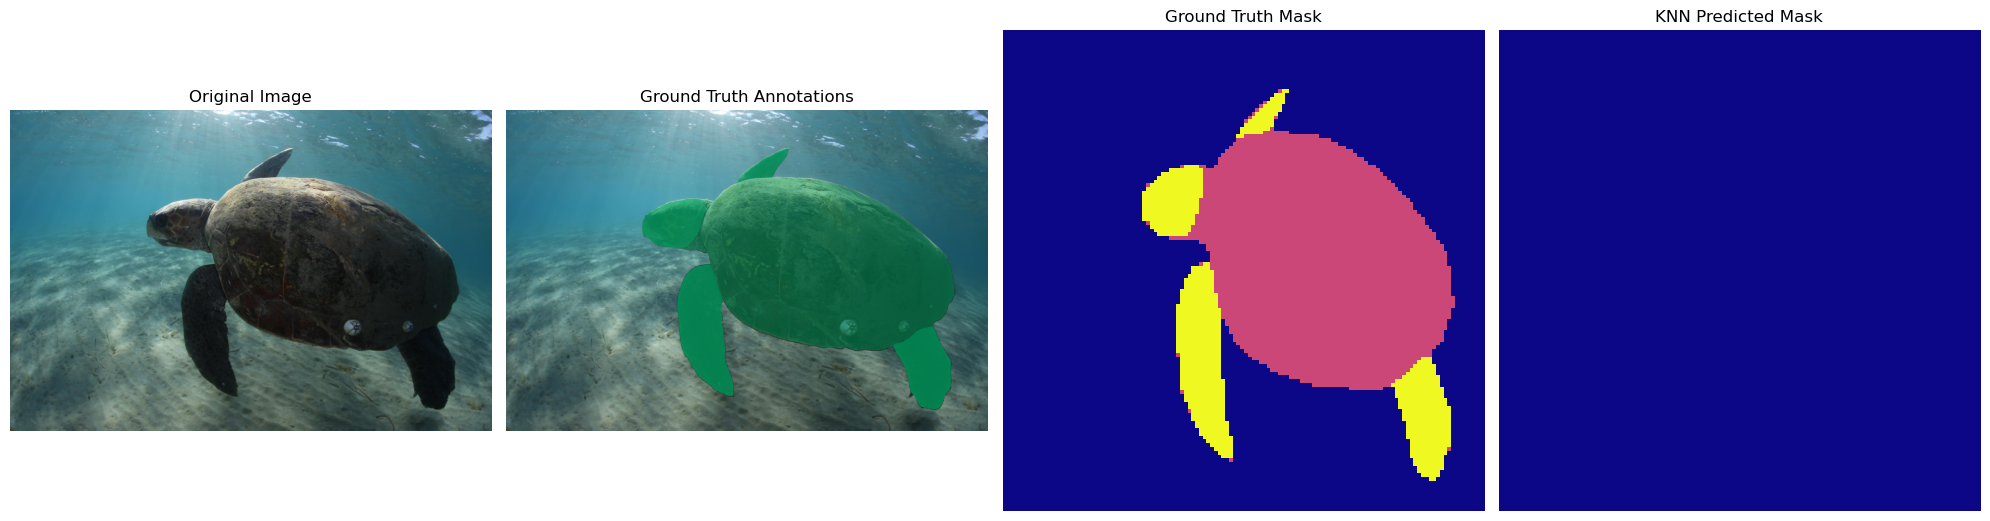

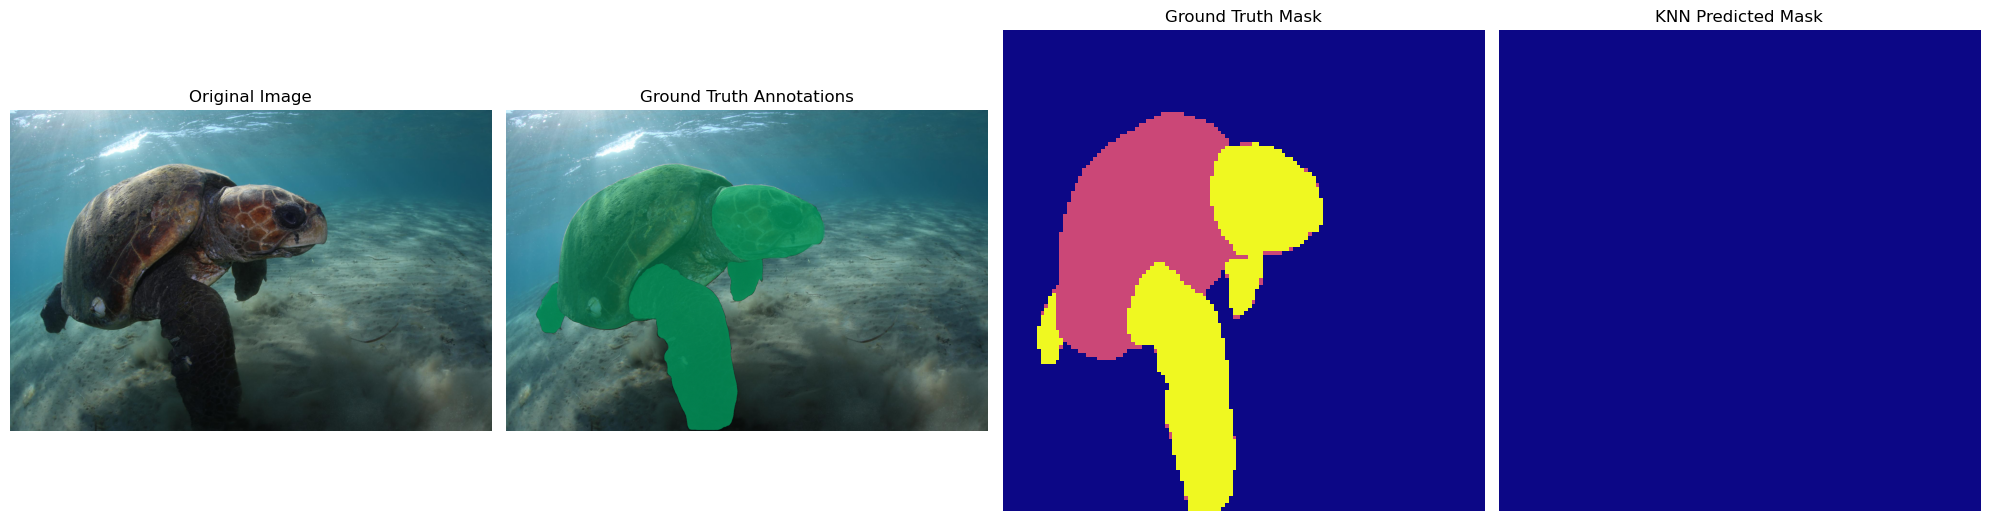

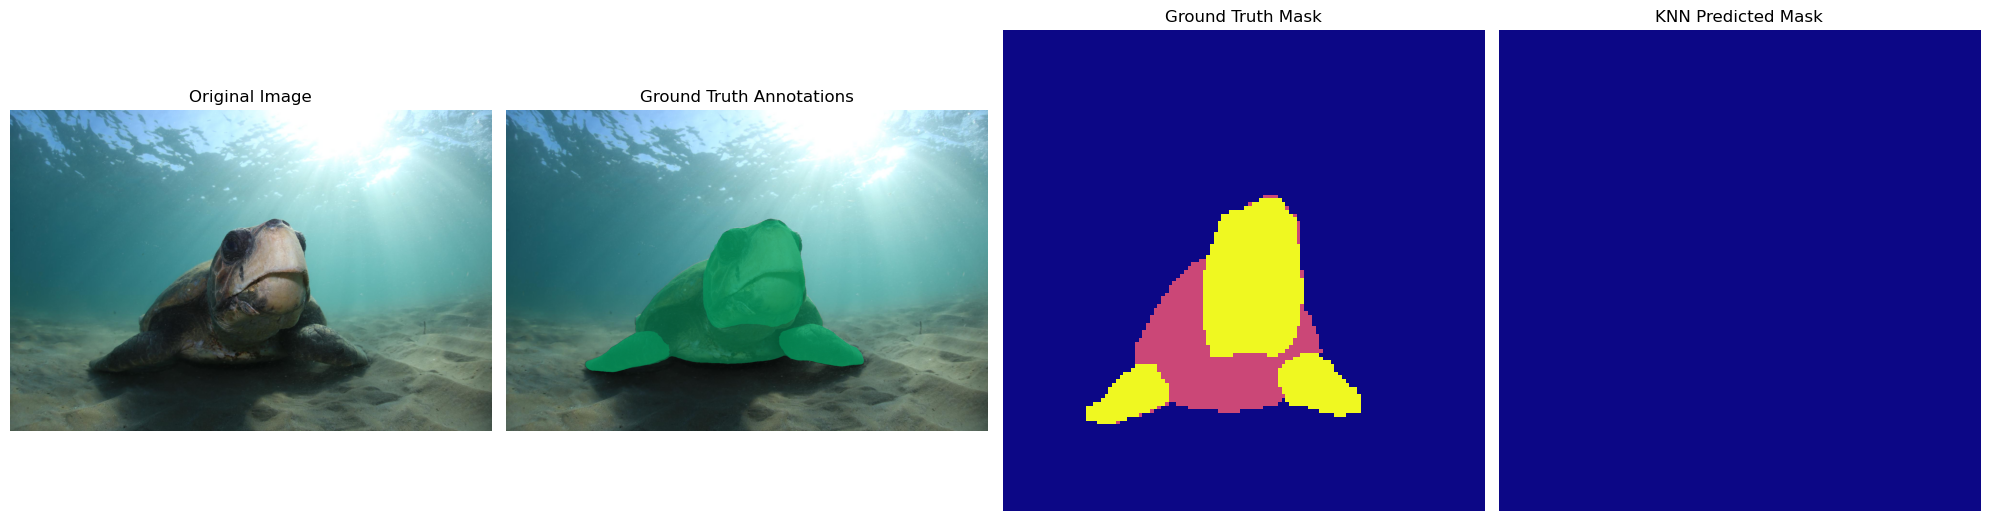

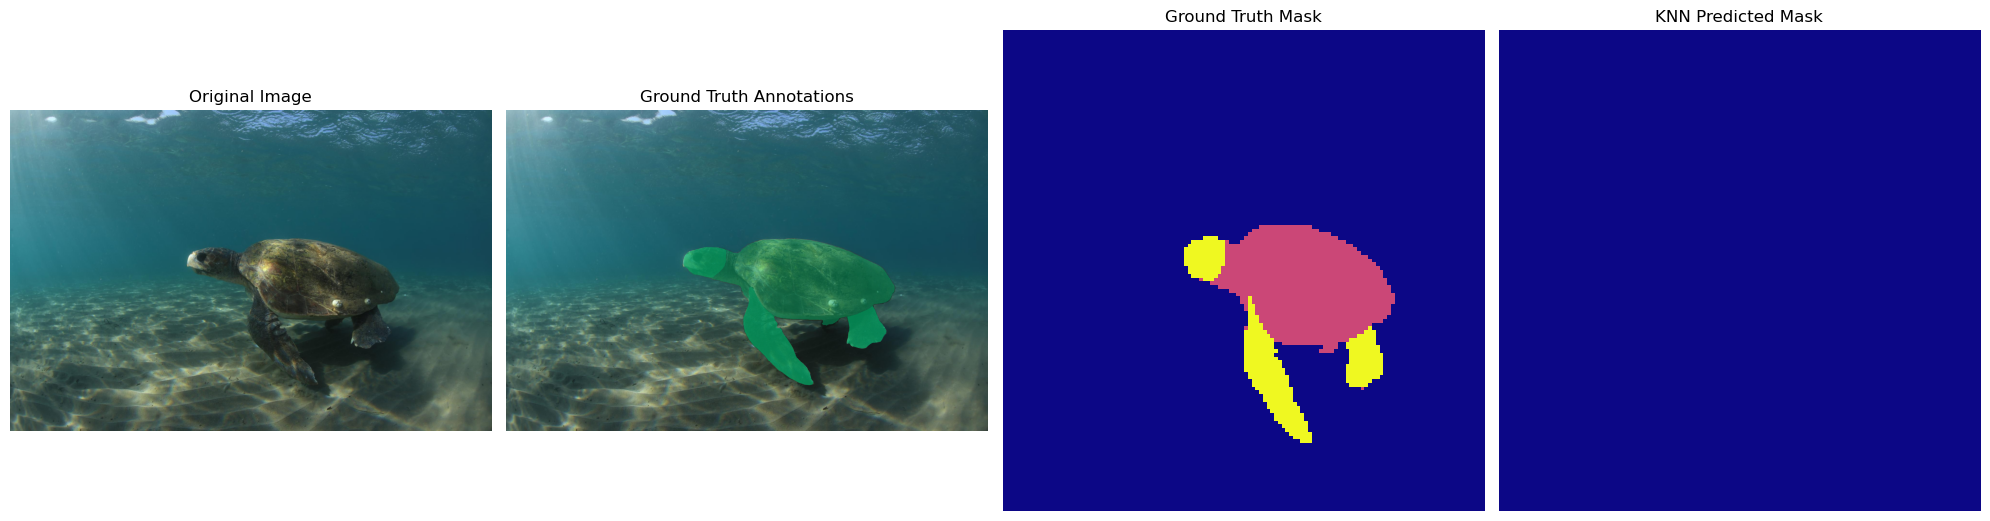

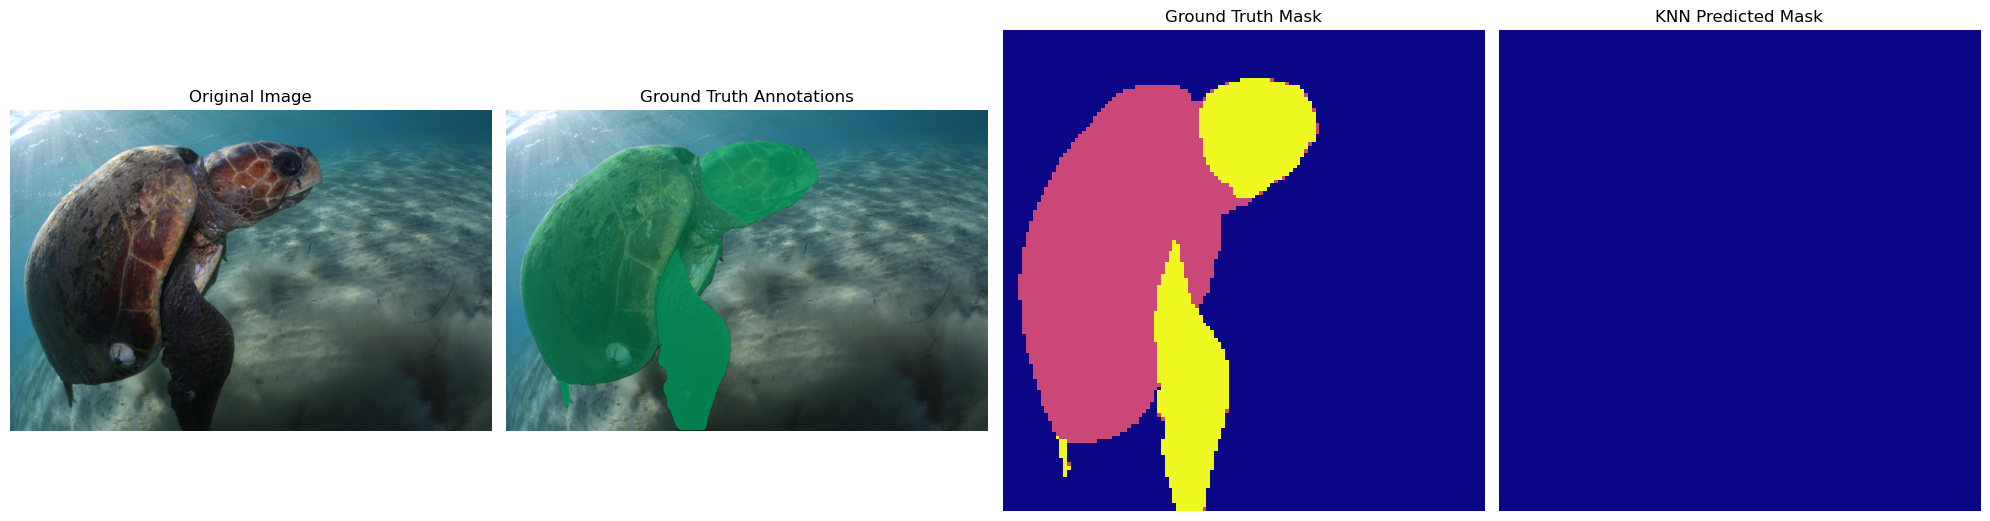

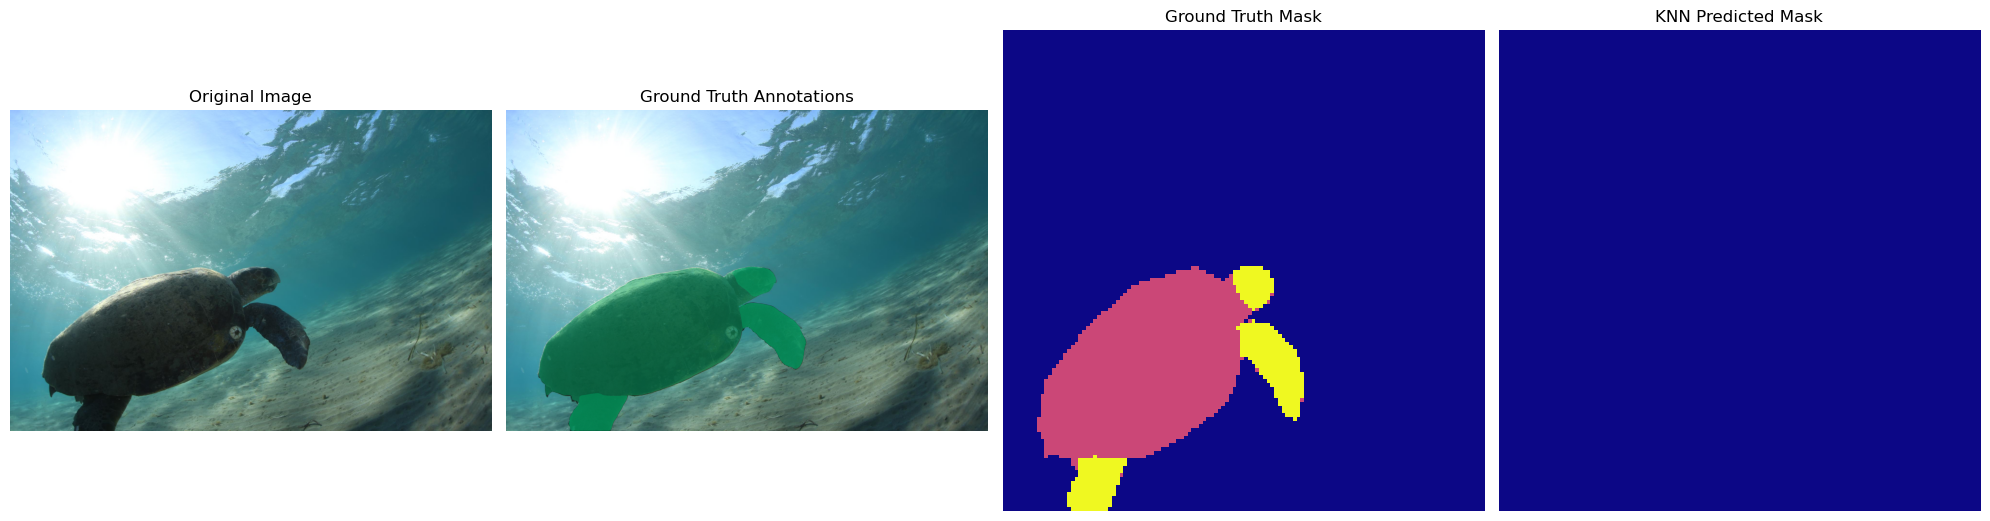

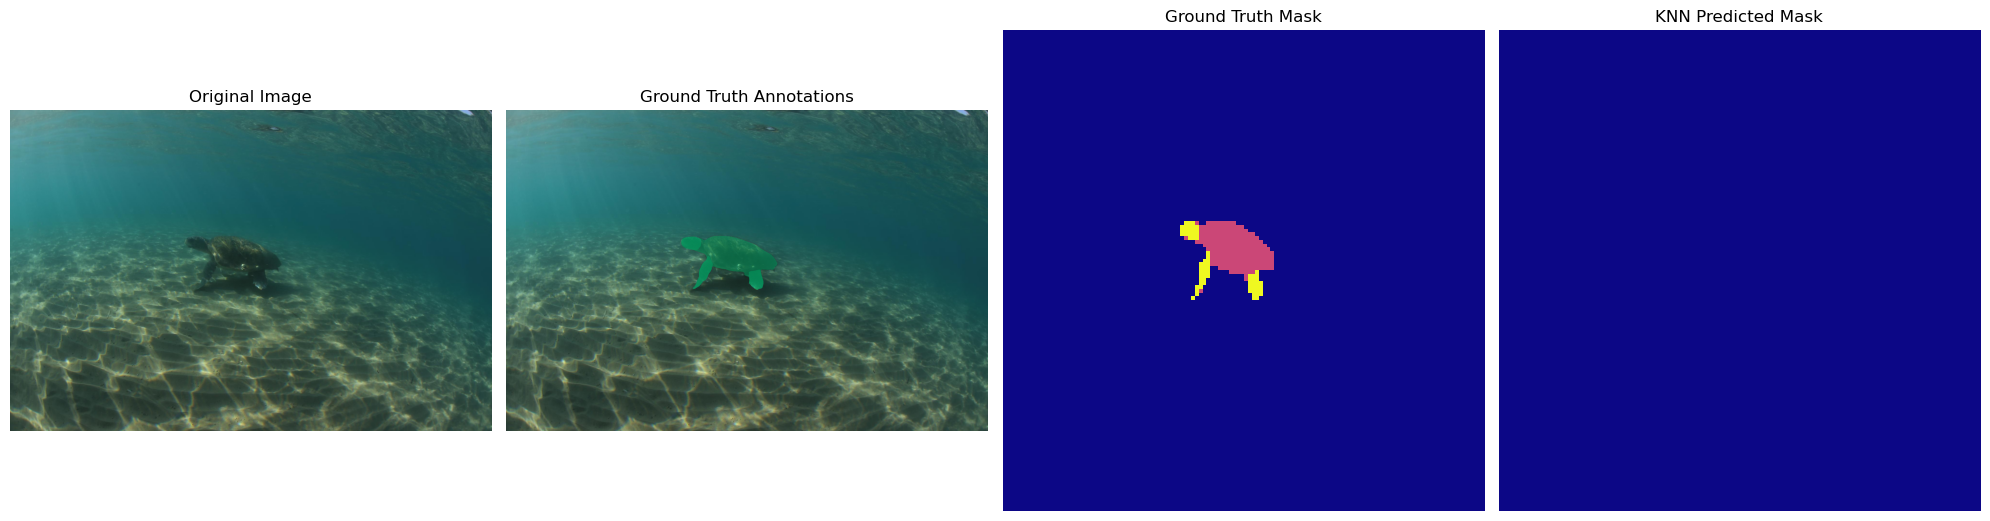

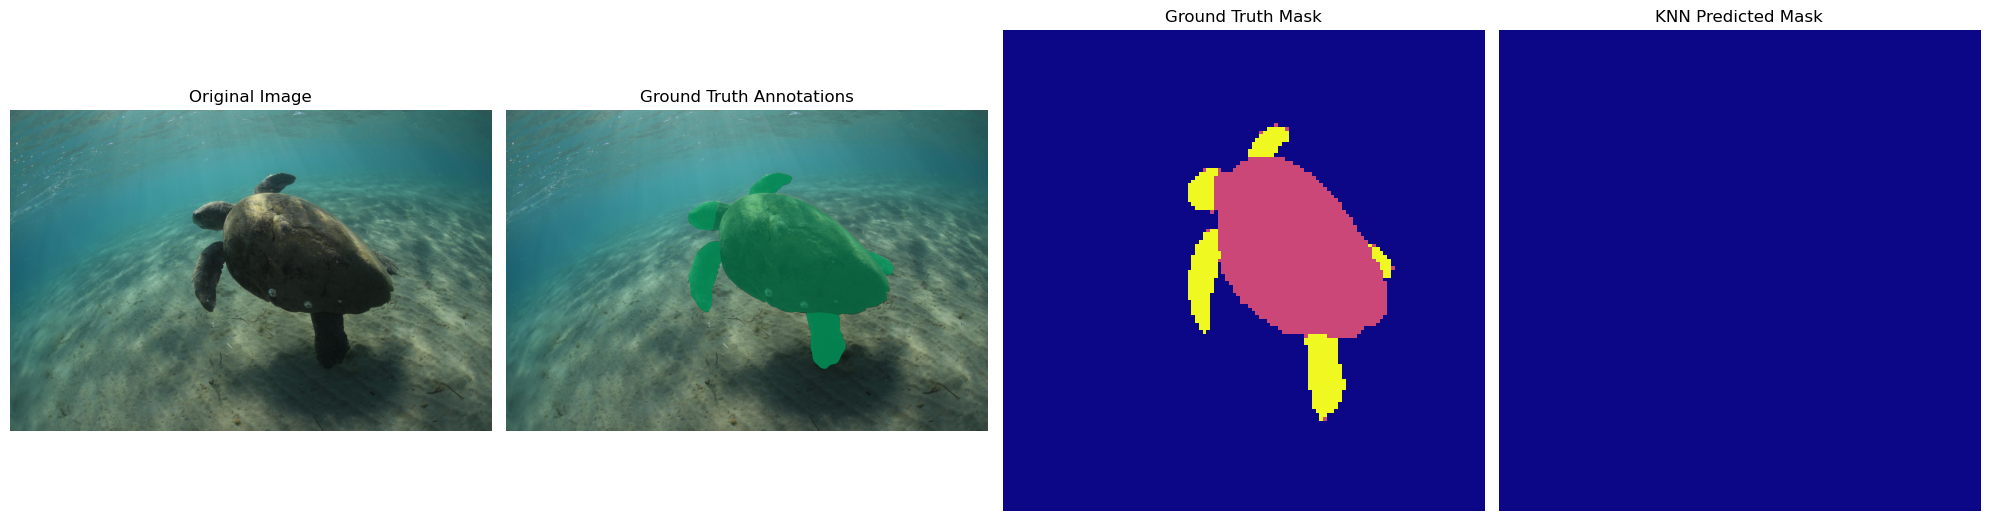

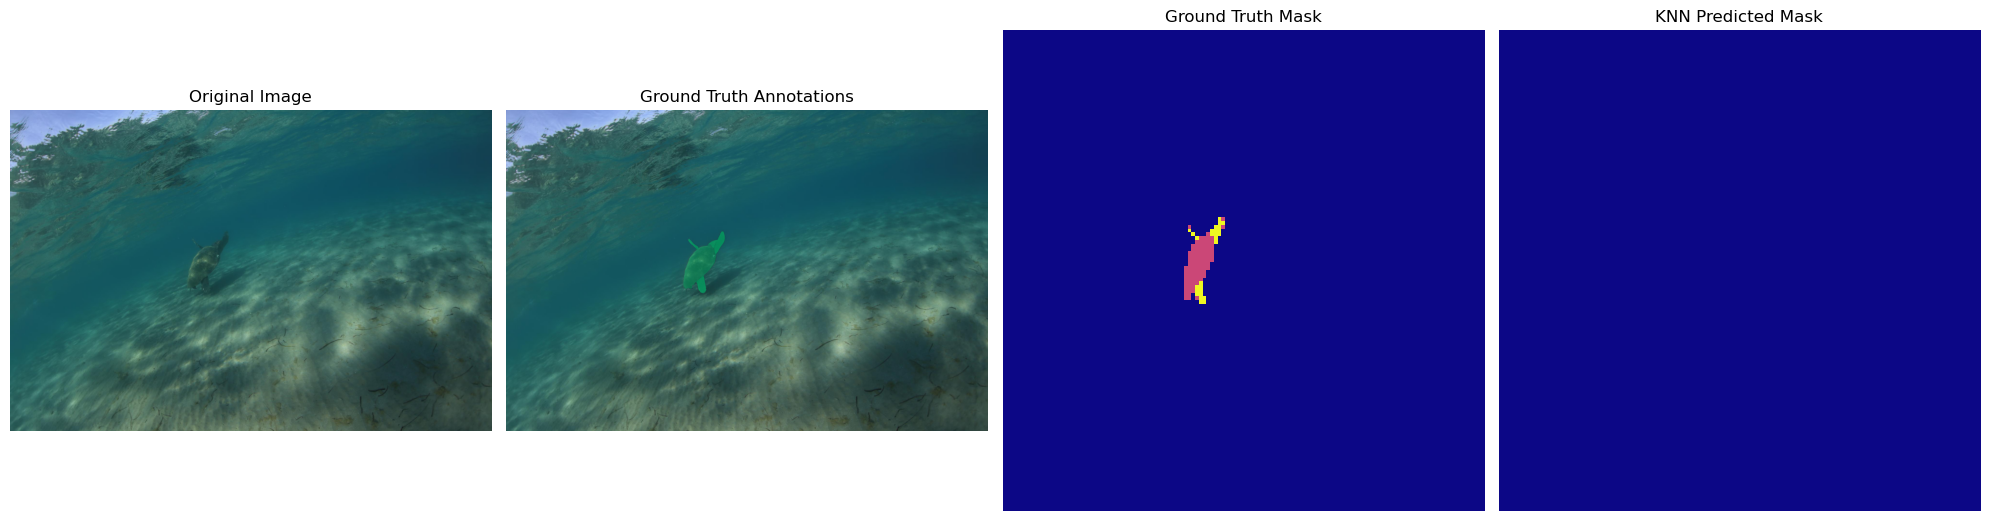

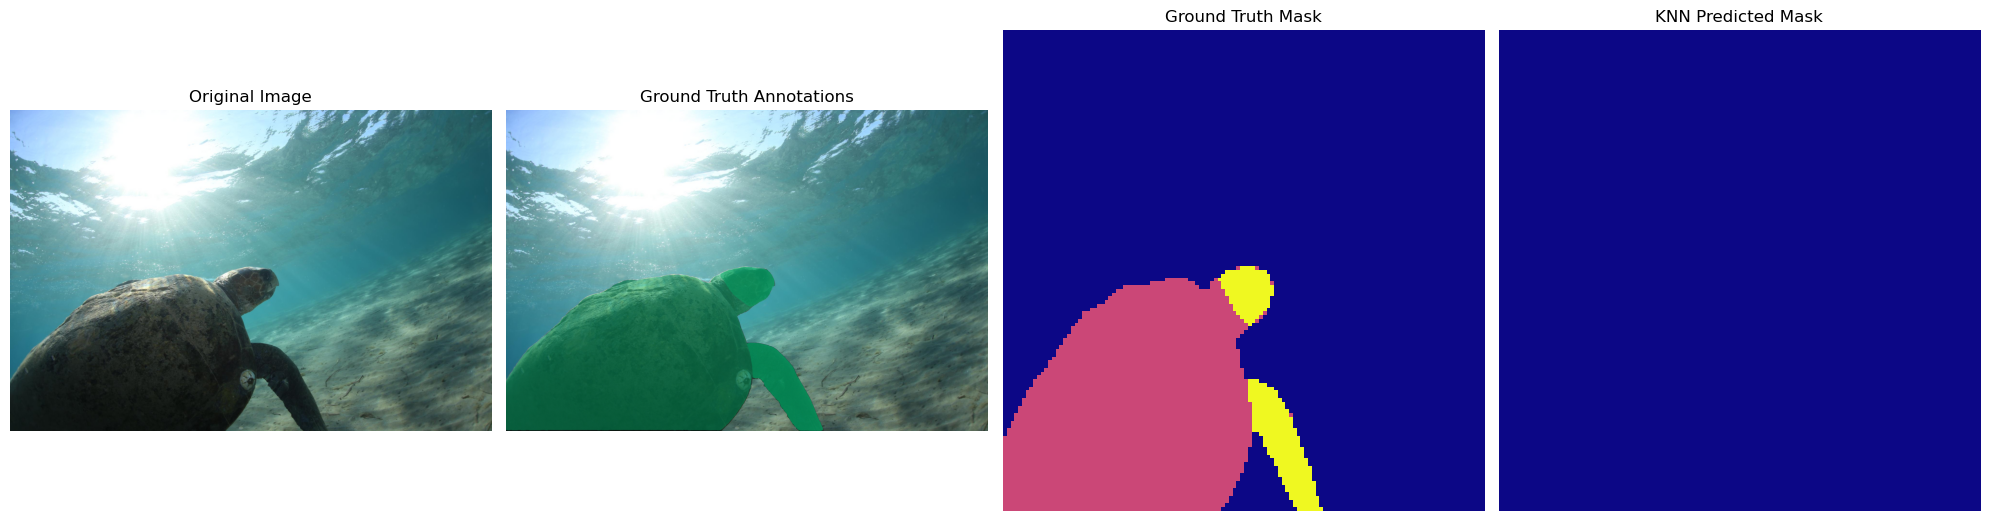

In [165]:
# Display segmentation results for a few test images
sample_image_ids = test_img_ids[:10]  # Use a small sample for quick visualization
display_images_with_segmentation(sample_image_ids, knn)


Implementing Feature Based Pixel Classification with KNN

In [213]:
import numpy as np
import cv2 as cv
from pycocotools.coco import COCO
from sklearn.neighbors import KNeighborsClassifier
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import albumentations as A
import os
import matplotlib.pyplot as plt

# Define transformation for resizing and normalizing
resize_transform = A.Compose([
    A.Resize(128, 128),  # Resize images to a consistent size
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

class FeatureBasedSeaTurtleDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.coco = COCO("./turtles-data/data/updated_annotations.json")
        self.img_ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image_data = self.coco.loadImgs([image_id])[0]
        image_path = os.path.join("./turtles-data/data", image_data["file_name"])
        
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        mask = self._getmask(image_id, image)

        # Resize image and mask
        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented["image"]
            mask = cv.resize(mask, (128, 128), interpolation=cv.INTER_NEAREST)

        # Convert image to HSV
        hsv_image = cv.cvtColor(image, cv.COLOR_RGB2HSV)

        # Prepare feature vectors: [R, G, B, H, S, V, x, y]
        h, w = image.shape[:2]
        coords = np.array([(x, y) for y in range(h) for x in range(w)])
        rgb_values = image.reshape(-1, 3)
        hsv_values = hsv_image.reshape(-1, 3)
        features = np.concatenate([rgb_values, hsv_values, coords], axis=1)

        # Flatten the mask
        labels = mask.flatten()

        return features, labels

    def _getmask(self, image_id, image):
        categories = {"turtle": 1, "flipper": 2, "head": 3}
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        for category_name, category_id in categories.items():
            ann_ids = self.coco.getAnnIds(imgIds=image_id, catIds=category_id, iscrowd=None)
            annotations = self.coco.loadAnns(ann_ids)

            temp_mask = np.zeros_like(mask)
            for ann in annotations:
                temp_mask += self.coco.annToMask(ann)

            if category_name == "turtle":
                mask[temp_mask > 0] = 1
            elif category_name == "flipper":
                mask[temp_mask > 0] = 2
            elif category_name == "head":
                mask[temp_mask > 0] = 3

        return mask


In [ ]:
# Load metadata and map image IDs
metadata_path = "turtles-data/data/metadata_splits.csv"
metadata = pd.read_csv(metadata_path)

cleaned_dataset = FeatureBasedSeaTurtleDataset(
    root="turtles-data/data/images",
    #annotation="turtles-data/data/updated_annotations.json",
    transforms=resize_transform,
)

#coco = FeatureBasedSeaTurtleDataset([]).coco
#image_ids = coco.getImgIds()

# Create a mapping for easy access and retrieval of imgs
img_to_filename = {img_id: cleaned_dataset.coco.loadImgs(img_id)[0]["file_name"] for img_id in cleaned_dataset.img_ids}
file_to_img = {v: k for k, v in img_to_filename.items()}

# Filter img_ids for each split based on `split_open` in the metadata. As per defined in the assignment specs
train_img_ids = [file_to_img[filename] for filename in metadata[metadata["split_open"] == "train"]["file_name"] if filename in file_to_img]
val_img_ids = [file_to_img[filename] for filename in metadata[metadata["split_open"] == "valid"]["file_name"] if filename in file_to_img]
test_img_ids = [file_to_img[filename] for filename in metadata[metadata["split_open"] == "test"]["file_name"] if filename in file_to_img]

# Verify the size of each split
train_size, val_size, test_size = len(train_img_ids), len(val_img_ids), len(test_img_ids)

# Create subset datasets for each split
train_dataset = Subset(cleaned_dataset, [cleaned_dataset.img_ids.index(img_id) for img_id in train_img_ids])
val_dataset = Subset(cleaned_dataset, [cleaned_dataset.img_ids.index(img_id) for img_id in val_img_ids])
test_dataset = Subset(cleaned_dataset, [cleaned_dataset.img_ids.index(img_id) for img_id in test_img_ids])

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

X_train, y_train = [], []

print("Processing training data...")
for features, labels in train_loader:
    X_train.extend(features.numpy())
    y_train.extend(labels.numpy())

X_train = np.vstack(X_train)
y_train = np.concatenate(y_train)

# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)


loading annotations into memory...
Done (t=183.30s)
creating index...
index created!
Processing training data...


In [ ]:
def display_images_with_segmentation(image_ids, knn_model):
    for image_id in image_ids:
        img_info = coco.loadImgs(image_id)[0]
        image_path = f"turtles-data/data/{img_info['file_name']}"
        image = np.array(Image.open(image_path))

        # Resize for prediction
        image_resized = cv.resize(image, (128, 128))
        hsv_image = cv.cvtColor(image_resized, cv.COLOR_RGB2HSV)
        coords = np.array([(x, y) for y in range(128) for x in range(128)])
        rgb_values = image_resized.reshape(-1, 3)
        hsv_values = hsv_image.reshape(-1, 3)
        features = np.concatenate([rgb_values, hsv_values, coords], axis=1)

        # Predict mask
        pred_mask_flat = knn_model.predict(features)
        pred_mask = pred_mask_flat.reshape((128, 128))

        # Display the results
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(pred_mask, cmap="plasma")
        plt.title("Feature Based Pixel Classification with KNN Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()



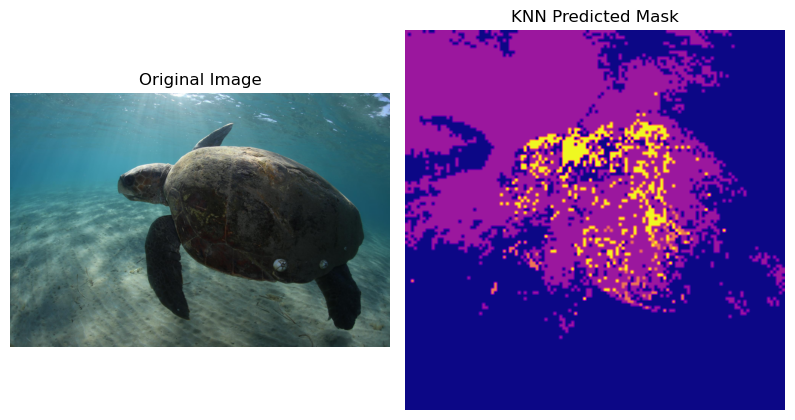

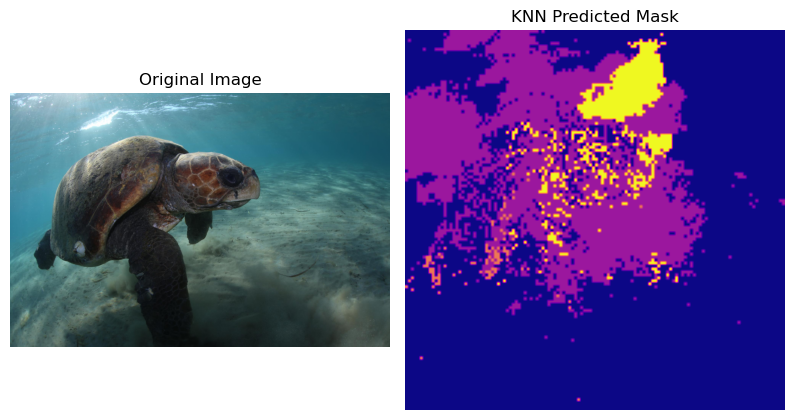

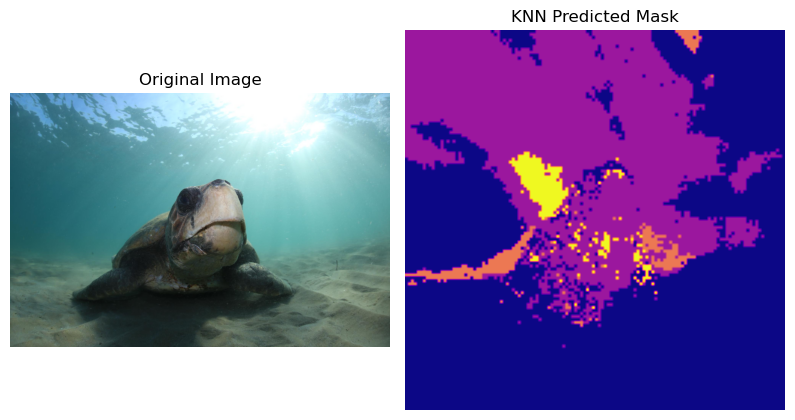

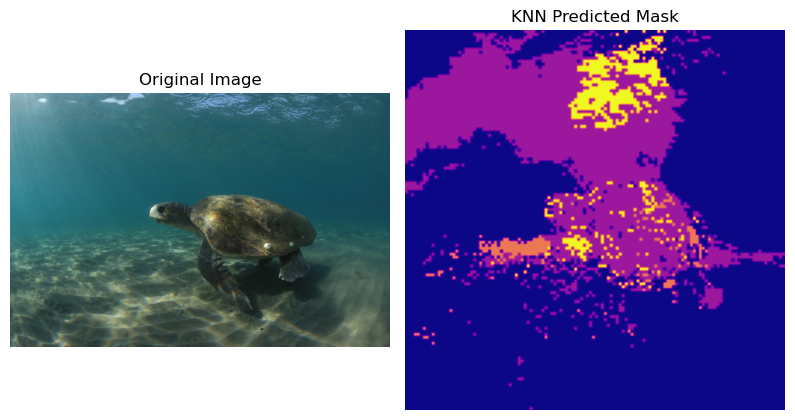

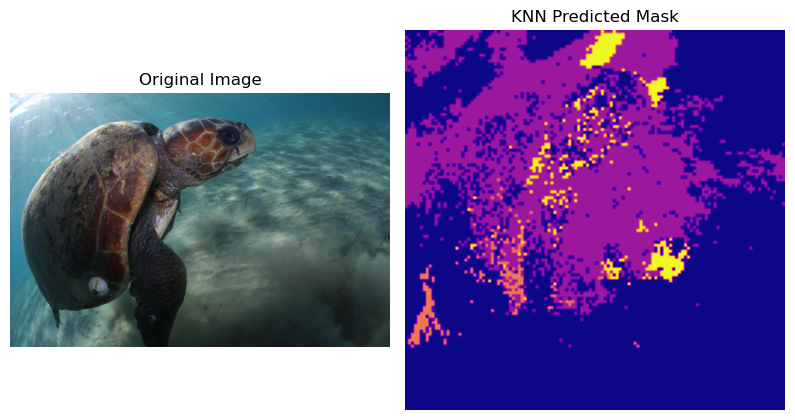

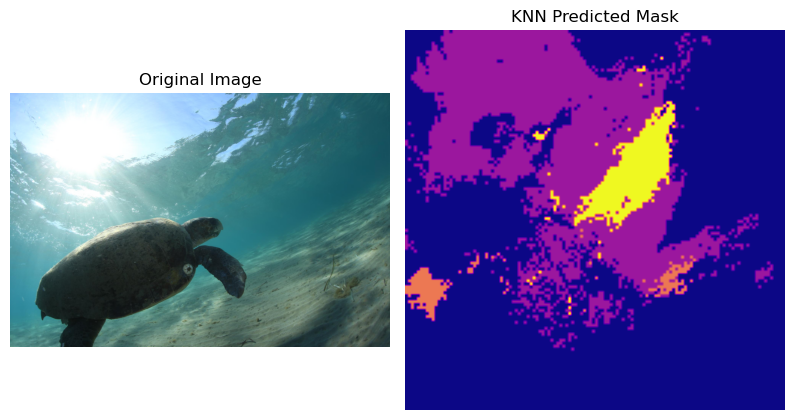

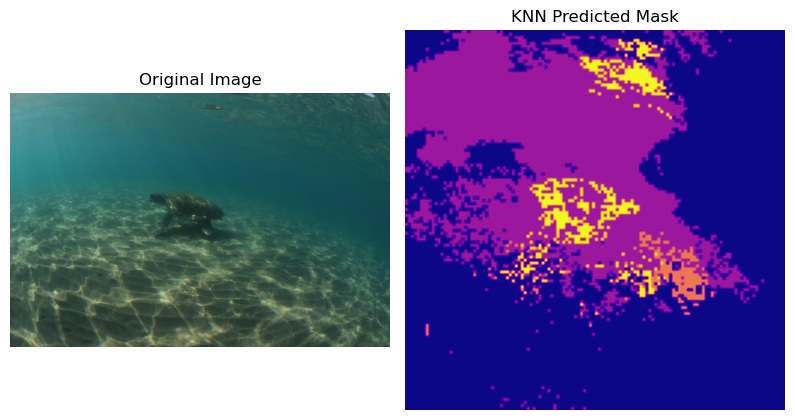

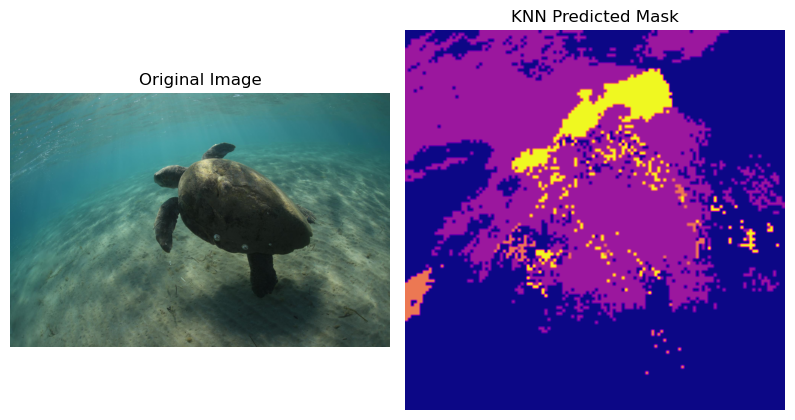

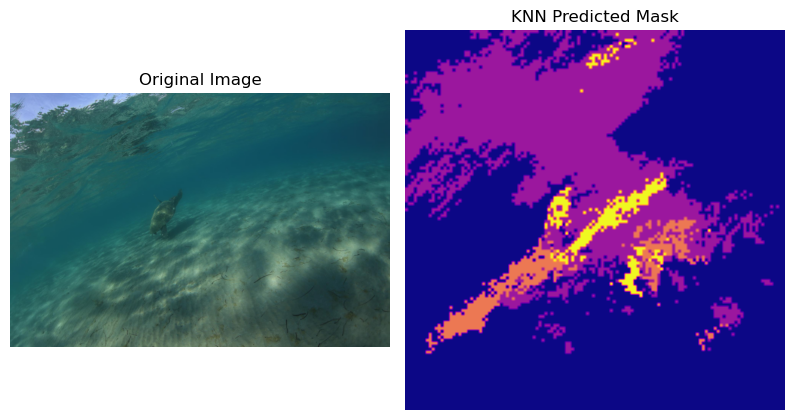

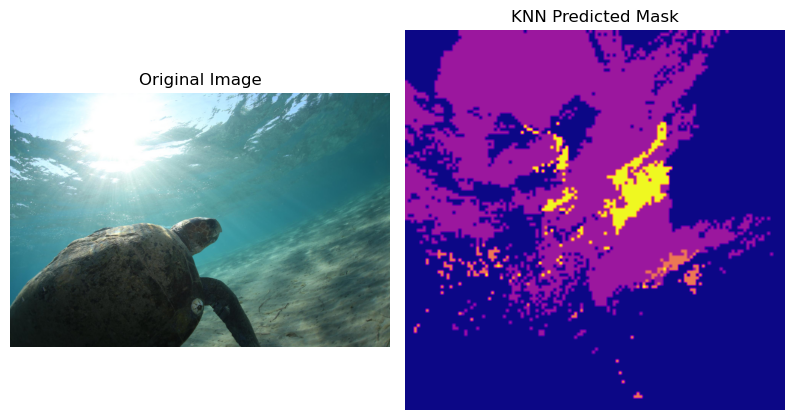

In [ ]:
# Display segmentation results for a few test images
sample_image_ids = test_img_ids[:10]  # Use a small sample for quick visualization
display_images_with_segmentation(sample_image_ids, knn)

